# Loan Default Prediction - Part 08 - Feature Discretization with Random Forest

This is an exploratory project for me to apply what I have learned in the Data Science and Machine Learning courses that I took this year. The data is from a Kaggle competition [Loan Default Prediction](https://www.kaggle.com/c/loan-default-prediction). 

This is Part 08 of the project: Feature Discretization with Random Forest.

The [sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) library has an API to retrieve the decision path of each example from each tree, in terms of the child chosen at each node. The hierarchy of the decision tree contains a lot of information. To name a few, the importance of each feature, and the combined effects of multiple features. Therefore, decision paths can be viewed as discretized features and can be added to enhance the dataset.

I will first load the data.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import time
import project_utils as utils

In [2]:
# Load the training data (imputed and normalized) from the CSV file
df, X, y = utils.load_csv('train_v2_preprocessed_normalized.csv')

# Separate training and validation sets
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_train, y_train, X_valid, y_valid = utils.split_data(kf, X, y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f3 to loss
dtypes: float64(1789)
memory usage: 1.4 GB


## Random Forest Decision Paths

I pick one of the best-performing models from the previous part of my project. I choose to use __max_depth__ as the constraint because I will have the same length of decision paths in this way. First, I train the model using the [sklearn.ensemble.RandomForestClassifier](scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) API. Here, I use all the data instead of splitting the data into a training set and a validation set because I am performing feature discretization rather than fitting a model that will be used for prediction.

In [3]:
# Define weights for unbalanced classes

class_weight = {0: 1., 1: 10.}

Time elapsed (Training): 5.3223 s
RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 10.0},
            criterion='gini', max_depth=6, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy (Training): 0.580248
ROCAUC Score (Training): 0.703557
PRAUC Score (Training): 0.136120
Accuracy (Validation): 0.581702
ROCAUC Score (Validation): 0.669016
PRAUC Score (Validation): 0.097744
Time elapsed (Evaluation): 1.6525 s


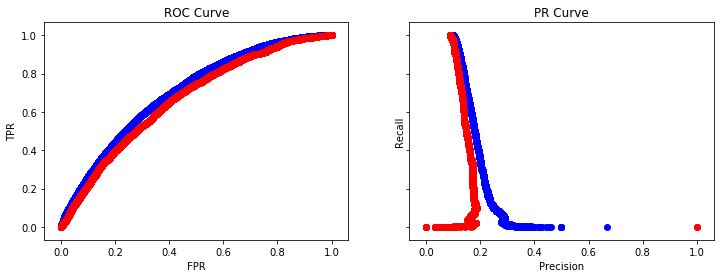

In [4]:
# Train the model and evaluate

from sklearn import ensemble
clf = ensemble.RandomForestClassifier(class_weight=class_weight, max_depth=6)
fit_time = utils.train_model(clf, X_train, y_train)
acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)

As both the training and the validation set are used in training this model, the curves and the metrics are very close, as expected. Let's take a look at the path of one example.

In [5]:
# Get the decision paths for all data

path = clf.decision_path(X)
print(path[0].shape)
print(path[1])

(105471, 1230)
[   0  125  250  371  490  611  736  863  982 1105 1230]


In [6]:
print(path[0][0])

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 8)	1
  (0, 10)	1
  (0, 125)	1
  (0, 126)	1
  (0, 127)	1
  (0, 128)	1
  (0, 129)	1
  (0, 133)	1
  (0, 135)	1
  (0, 250)	1
  (0, 308)	1
  (0, 340)	1
  (0, 356)	1
  (0, 364)	1
  (0, 368)	1
  (0, 369)	1
  (0, 371)	1
  (0, 372)	1
  (0, 402)	1
  (0, 403)	1
  :	:
  (0, 785)	1
  (0, 793)	1
  (0, 794)	1
  (0, 796)	1
  (0, 863)	1
  (0, 864)	1
  (0, 896)	1
  (0, 897)	1
  (0, 905)	1
  (0, 906)	1
  (0, 907)	1
  (0, 982)	1
  (0, 983)	1
  (0, 984)	1
  (0, 1000)	1
  (0, 1001)	1
  (0, 1005)	1
  (0, 1006)	1
  (0, 1105)	1
  (0, 1167)	1
  (0, 1199)	1
  (0, 1215)	1
  (0, 1216)	1
  (0, 1217)	1
  (0, 1219)	1


This is a sparse matrix, and only the entries with value 1 are printed. Now, I concatenate these to the original DataFrame as additional features.

In [7]:
df_path = pd.DataFrame(path[0].toarray())
df_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1230 entries, 0 to 1229
dtypes: int64(1230)
memory usage: 989.8 MB


In [8]:
# Make a DataFrame with only the paths and 'loss'

df_path_only = pd.concat([df_path, df['loss']], axis=1)
df_path_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1231 entries, 0 to loss
dtypes: float64(1), int64(1230)
memory usage: 990.6 MB


In [9]:
# Save the new features to a CSV file

#df_path_only.to_csv('train_v2_rf_path_only.csv')

In [10]:
# Add original features to the DataFrame

df_combined = pd.concat([X, df_path_only], axis=1)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 3019 entries, f3 to loss
dtypes: float64(1789), int64(1230)
memory usage: 2.4 GB


In [12]:
# Save the new features to a CSV file

#df_combined.to_csv('train_v2_normalized_with_rf_path.csv')

## Using the Decision Path Features in Logistic Regression

I will use these new features to train a Logistic Regression model. First, I will train the reference model.

Time elapsed (Training): 44.0570 s
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906312
ROCAUC Score (Training): 0.736909
PRAUC Score (Training): 0.120929
Accuracy (Validation): 0.911780
ROCAUC Score (Validation): 0.712660
PRAUC Score (Validation): 0.091904
Time elapsed (Evaluation): 0.9627 s


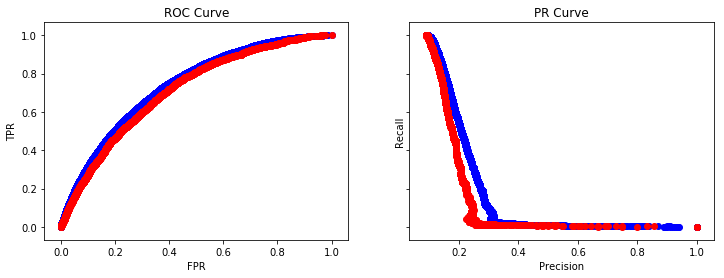

In [13]:
# Reference model trained with original normalized features, no class weights (Best result obtained in Part 03)

from sklearn import linear_model
clf = linear_model.LogisticRegression(C=0.01)
fit_time = utils.train_model(clf, X_train, y_train)
acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)

Time elapsed (Training): 185.9738 s
LogisticRegression(C=0.01, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.651453
ROCAUC Score (Training): 0.744557
PRAUC Score (Training): 0.118671
Accuracy (Validation): 0.641242
ROCAUC Score (Validation): 0.712974
PRAUC Score (Validation): 0.093177
Time elapsed (Evaluation): 0.8647 s


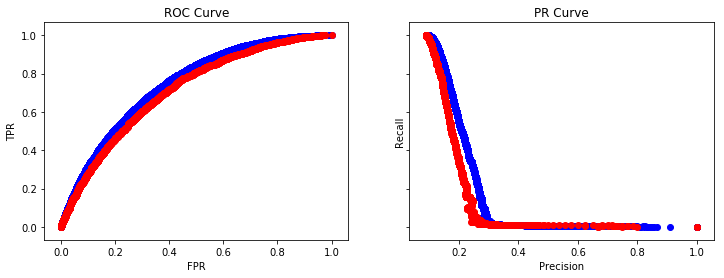

In [14]:
# Reference model trained with original normalized features, with class weights

from sklearn import linear_model
clf = linear_model.LogisticRegression(class_weight=class_weight, C=0.01)
fit_time = utils.train_model(clf, X_train, y_train)
acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)

Now I try the combined features with different degrees of regularization (controlled by __C__).

In [15]:
# Change X and y to combined features

X = df_combined.drop(['loss'], axis=1) # Features
y = (df_combined.loc[:,'loss'] > 0) # Labels
X_train, y_train, X_valid, y_valid = utils.split_data(kf, X, y)

In [16]:
# Define a set of Cs to try

Cs = [1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 1e-4]

----- C = 0.100000 -----
Time elapsed (Training): 184.7224 s
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906454
ROCAUC Score (Training): 0.775201
PRAUC Score (Training): 0.169834
Accuracy (Validation): 0.911259
ROCAUC Score (Validation): 0.702562
PRAUC Score (Validation): 0.087259
Time elapsed (Evaluation): 3.7308 s


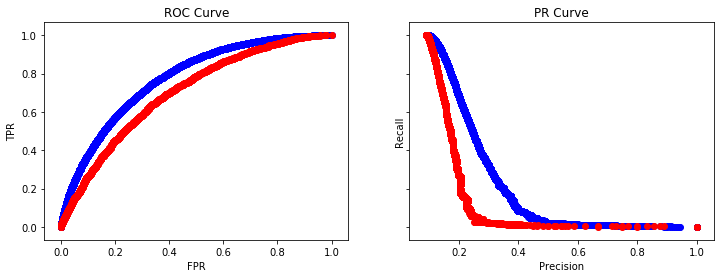

----- C = 0.050000 -----
Time elapsed (Training): 213.5100 s
LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906478
ROCAUC Score (Training): 0.777162
PRAUC Score (Training): 0.172553
Accuracy (Validation): 0.911448
ROCAUC Score (Validation): 0.703347
PRAUC Score (Validation): 0.087357
Time elapsed (Evaluation): 3.7518 s


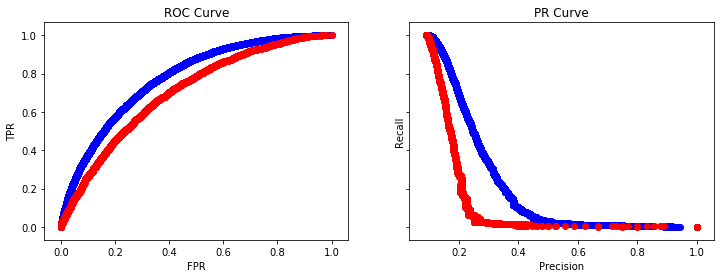

----- C = 0.020000 -----
Time elapsed (Training): 165.7472 s
LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906431
ROCAUC Score (Training): 0.770509
PRAUC Score (Training): 0.162818
Accuracy (Validation): 0.911543
ROCAUC Score (Validation): 0.707979
PRAUC Score (Validation): 0.089219
Time elapsed (Evaluation): 3.6008 s


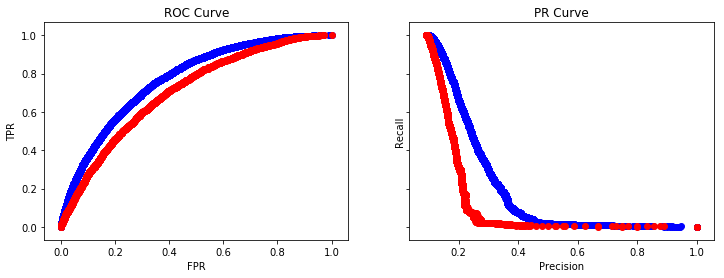

----- C = 0.010000 -----
Time elapsed (Training): 116.6289 s
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906514
ROCAUC Score (Training): 0.764331
PRAUC Score (Training): 0.154517
Accuracy (Validation): 0.911543
ROCAUC Score (Validation): 0.710898
PRAUC Score (Validation): 0.090508
Time elapsed (Evaluation): 3.6318 s


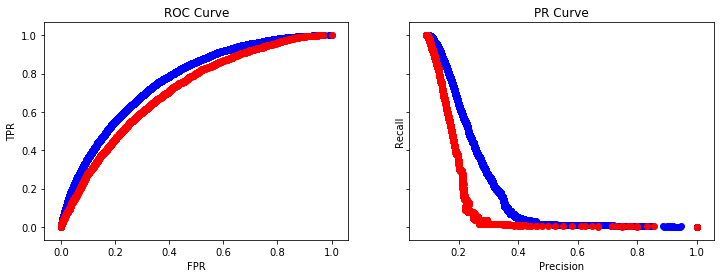

----- C = 0.005000 -----
Time elapsed (Training): 61.5854 s
LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906466
ROCAUC Score (Training): 0.757217
PRAUC Score (Training): 0.145659
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.712606
PRAUC Score (Validation): 0.091145
Time elapsed (Evaluation): 3.6029 s


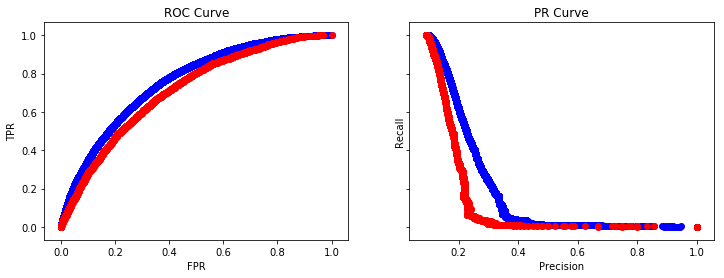

----- C = 0.002000 -----
Time elapsed (Training): 44.1609 s
LogisticRegression(C=0.002, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906407
ROCAUC Score (Training): 0.746515
PRAUC Score (Training): 0.133675
Accuracy (Validation): 0.912017
ROCAUC Score (Validation): 0.712182
PRAUC Score (Validation): 0.090843
Time elapsed (Evaluation): 3.5779 s


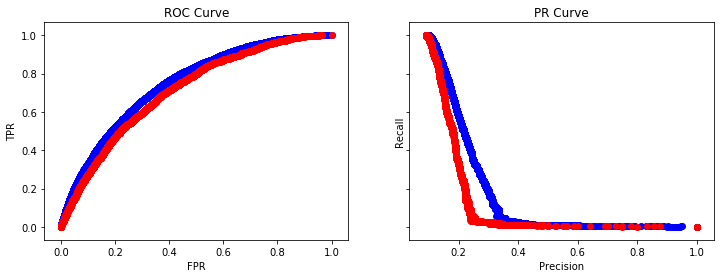

----- C = 0.001000 -----
Time elapsed (Training): 34.3671 s
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906383
ROCAUC Score (Training): 0.737476
PRAUC Score (Training): 0.124552
Accuracy (Validation): 0.912112
ROCAUC Score (Validation): 0.709299
PRAUC Score (Validation): 0.089054
Time elapsed (Evaluation): 3.5629 s


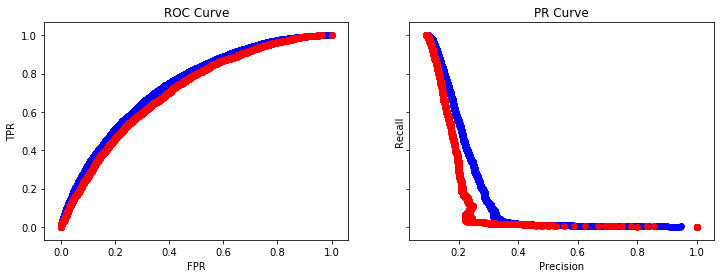

----- C = 0.000500 -----
Time elapsed (Training): 32.3957 s
LogisticRegression(C=0.0005, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906360
ROCAUC Score (Training): 0.727591
PRAUC Score (Training): 0.115191
Accuracy (Validation): 0.912017
ROCAUC Score (Validation): 0.704187
PRAUC Score (Validation): 0.084762
Time elapsed (Evaluation): 3.6308 s


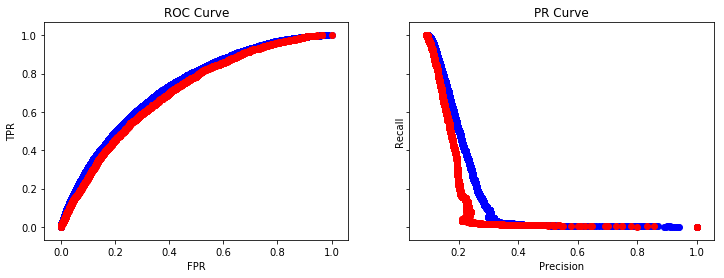

----- C = 0.000200 -----
Time elapsed (Training): 20.4185 s
LogisticRegression(C=0.0002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906312
ROCAUC Score (Training): 0.713602
PRAUC Score (Training): 0.103348
Accuracy (Validation): 0.912064
ROCAUC Score (Validation): 0.694791
PRAUC Score (Validation): 0.077360
Time elapsed (Evaluation): 3.5989 s


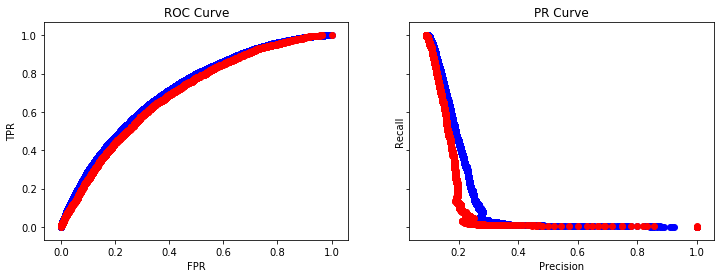

----- C = 0.000100 -----
Time elapsed (Training): 18.3272 s
LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906217
ROCAUC Score (Training): 0.703170
PRAUC Score (Training): 0.094356
Accuracy (Validation): 0.911970
ROCAUC Score (Validation): 0.686789
PRAUC Score (Validation): 0.072744
Time elapsed (Evaluation): 3.6088 s


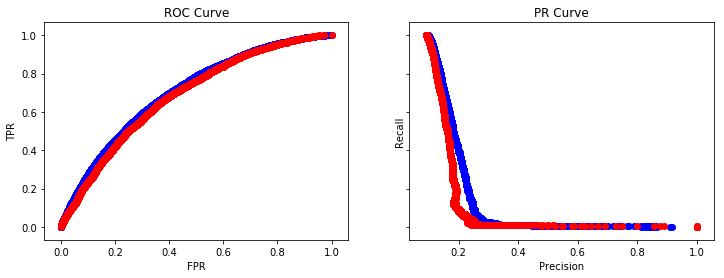

In [17]:
# Train the models with combined features

fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for C in Cs:
    print('----- C = %f -----' % C)
    clf = linear_model.LogisticRegression(C=C)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

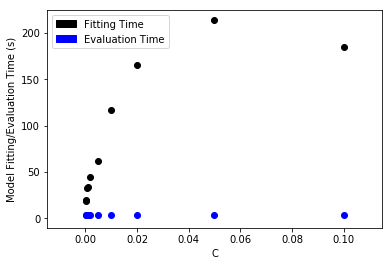

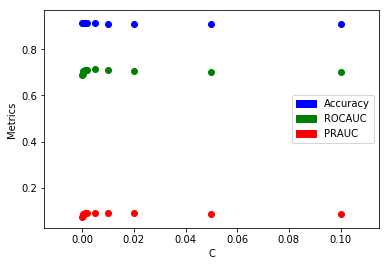

      0_C  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0  0.1000    0.911259  0.702562  0.087259  184.722435     3.730811
1  0.0500    0.911448  0.703347  0.087357  213.509998     3.751790
2  0.0200    0.911543  0.707979  0.089219  165.747182     3.600835
3  0.0100    0.911543  0.710898  0.090508  116.628859     3.631830
4  0.0050    0.911827  0.712606  0.091145   61.585381     3.602852
5  0.0020    0.912017  0.712182  0.090843   44.160918     3.577860
6  0.0010    0.912112  0.709299  0.089054   34.367066     3.562851
7  0.0005    0.912017  0.704187  0.084762   32.395681     3.630843
8  0.0002    0.912064  0.694791  0.077360   20.418496     3.598853
9  0.0001    0.911970  0.686789  0.072744   18.327161     3.608838


             0_C  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count  10.000000   10.000000  10.000000  10.000000   10.000000    10.000000
mean    0.018880    0.911780   0.704464   0.086025   89.186318     3.629736
std     0.032431    0.000305   0.

In [18]:
utils.plot_metrics (Cs, 'C', True, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

----- C = 0.100000 -----
Time elapsed (Training): 198.6627 s
LogisticRegression(C=0.1, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.665379
ROCAUC Score (Training): 0.775845
PRAUC Score (Training): 0.151217
Accuracy (Validation): 0.650438
ROCAUC Score (Validation): 0.704521
PRAUC Score (Validation): 0.088535
Time elapsed (Evaluation): 3.6069 s


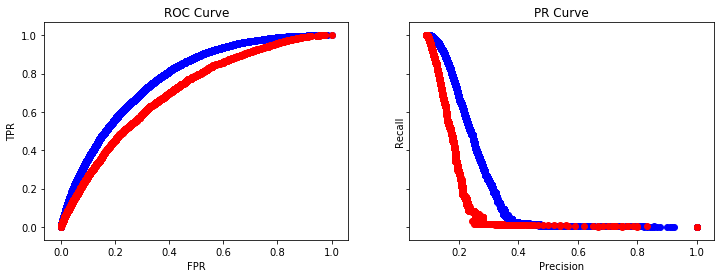

----- C = 0.050000 -----
Time elapsed (Training): 324.7385 s
LogisticRegression(C=0.05, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.675026
ROCAUC Score (Training): 0.786622
PRAUC Score (Training): 0.163337
Accuracy (Validation): 0.655037
ROCAUC Score (Validation): 0.697749
PRAUC Score (Validation): 0.085801
Time elapsed (Evaluation): 3.7012 s


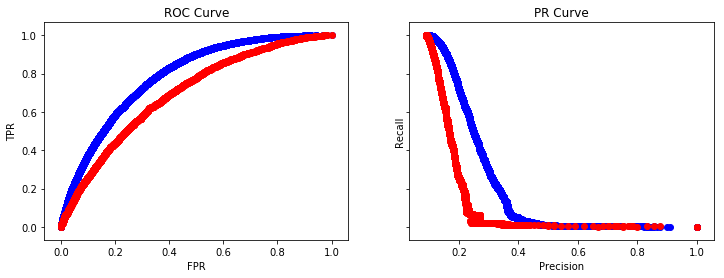

----- C = 0.020000 -----
Time elapsed (Training): 273.8048 s
LogisticRegression(C=0.02, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.672194
ROCAUC Score (Training): 0.782815
PRAUC Score (Training): 0.158795
Accuracy (Validation): 0.653283
ROCAUC Score (Validation): 0.701519
PRAUC Score (Validation): 0.087539
Time elapsed (Evaluation): 3.6328 s


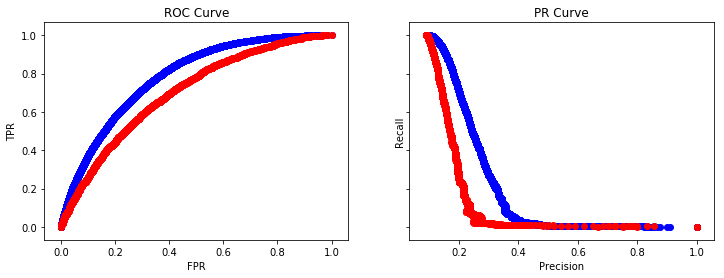

----- C = 0.010000 -----
Time elapsed (Training): 171.2954 s
LogisticRegression(C=0.01, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.668602
ROCAUC Score (Training): 0.778995
PRAUC Score (Training): 0.154546
Accuracy (Validation): 0.651292
ROCAUC Score (Validation): 0.704862
PRAUC Score (Validation): 0.088869
Time elapsed (Evaluation): 3.6188 s


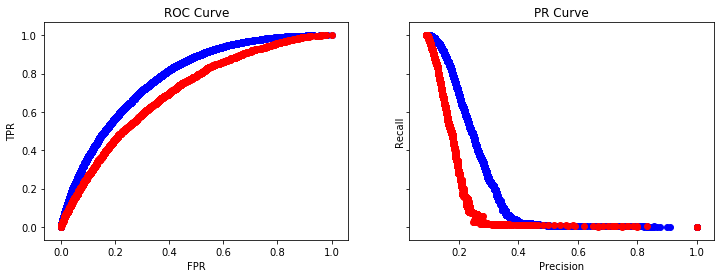

----- C = 0.005000 -----
Time elapsed (Training): 137.5512 s
LogisticRegression(C=0.005, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.664597
ROCAUC Score (Training): 0.774065
PRAUC Score (Training): 0.149499
Accuracy (Validation): 0.649016
ROCAUC Score (Validation): 0.708224
PRAUC Score (Validation): 0.090318
Time elapsed (Evaluation): 3.5689 s


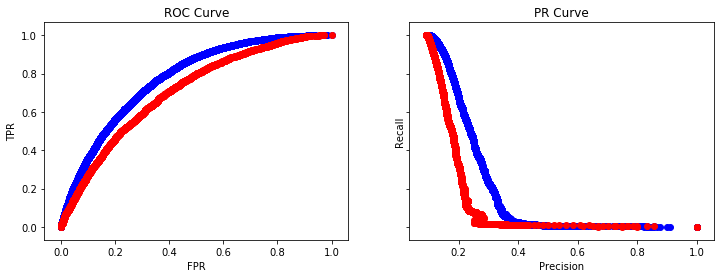

----- C = 0.002000 -----
Time elapsed (Training): 97.3570 s
LogisticRegression(C=0.002, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.657154
ROCAUC Score (Training): 0.765980
PRAUC Score (Training): 0.141669
Accuracy (Validation): 0.645177
ROCAUC Score (Validation): 0.712164
PRAUC Score (Validation): 0.091991
Time elapsed (Evaluation): 3.7088 s


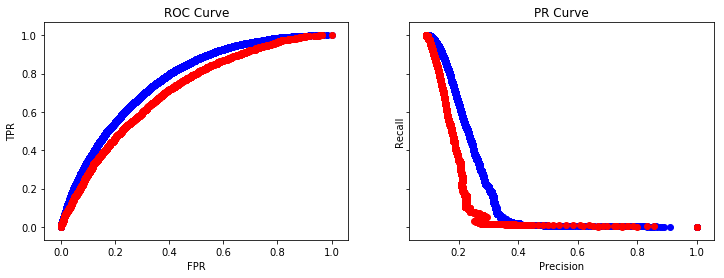

----- C = 0.001000 -----
Time elapsed (Training): 61.3764 s
LogisticRegression(C=0.001, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.650007
ROCAUC Score (Training): 0.758752
PRAUC Score (Training): 0.135111
Accuracy (Validation): 0.640721
ROCAUC Score (Validation): 0.713956
PRAUC Score (Validation): 0.092882
Time elapsed (Evaluation): 3.6318 s


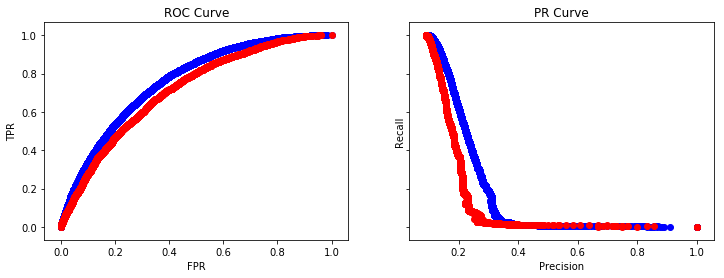

----- C = 0.000500 -----
Time elapsed (Training): 49.1174 s
LogisticRegression(C=0.0005, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.642007
ROCAUC Score (Training): 0.750687
PRAUC Score (Training): 0.128242
Accuracy (Validation): 0.635316
ROCAUC Score (Validation): 0.714093
PRAUC Score (Validation): 0.092890
Time elapsed (Evaluation): 3.6378 s


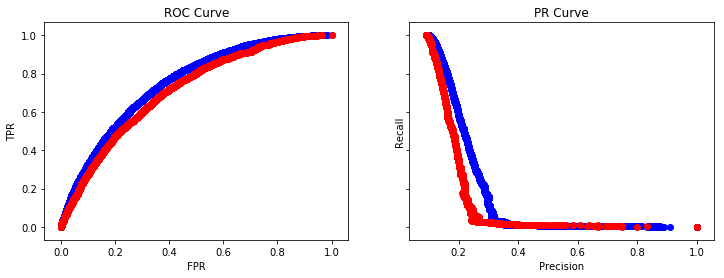

----- C = 0.000200 -----
Time elapsed (Training): 41.5917 s
LogisticRegression(C=0.0002, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.629812
ROCAUC Score (Training): 0.738835
PRAUC Score (Training): 0.118790
Accuracy (Validation): 0.624603
ROCAUC Score (Validation): 0.711103
PRAUC Score (Validation): 0.090750
Time elapsed (Evaluation): 3.6958 s


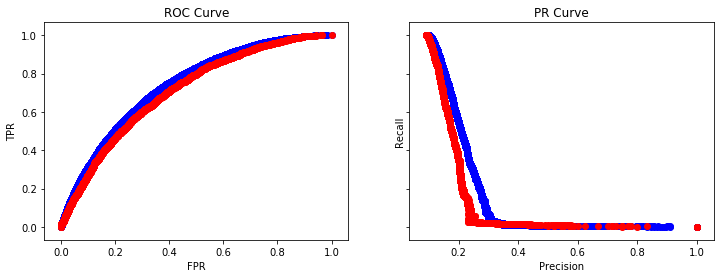

----- C = 0.000100 -----
Time elapsed (Training): 31.5629 s
LogisticRegression(C=0.0001, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.619690
ROCAUC Score (Training): 0.728846
PRAUC Score (Training): 0.110743
Accuracy (Validation): 0.617018
ROCAUC Score (Validation): 0.706271
PRAUC Score (Validation): 0.086717
Time elapsed (Evaluation): 4.9894 s


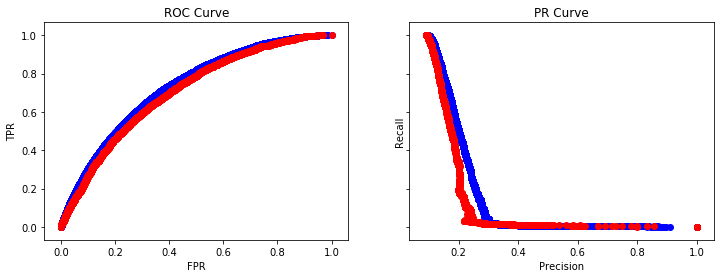

In [19]:
# Train the models with combined features and class weights

fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for C in Cs:
    print('----- C = %f -----' % C)
    clf = linear_model.LogisticRegression(class_weight=class_weight, C=C)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

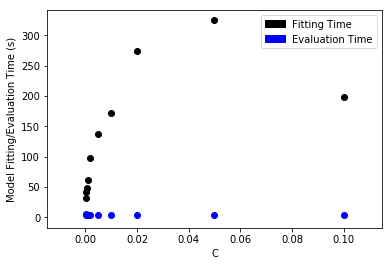

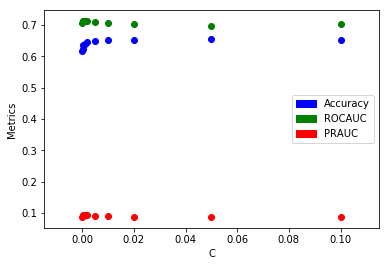

      0_C  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0  0.1000    0.650438  0.704521  0.088535  198.662696     3.606851
1  0.0500    0.655037  0.697749  0.085801  324.738452     3.701161
2  0.0200    0.653283  0.701519  0.087539  273.804775     3.632843
3  0.0100    0.651292  0.704862  0.088869  171.295431     3.618847
4  0.0050    0.649016  0.708224  0.090318  137.551181     3.568862
5  0.0020    0.645177  0.712164  0.091991   97.356987     3.708805
6  0.0010    0.640721  0.713956  0.092882   61.376446     3.631830
7  0.0005    0.635316  0.714093  0.092890   49.117353     3.637841
8  0.0002    0.624603  0.711103  0.090750   41.591738     3.695807
9  0.0001    0.617018  0.706271  0.086717   31.562932     4.989410


             0_C  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count  10.000000   10.000000  10.000000  10.000000   10.000000    10.000000
mean    0.018880    0.642190   0.707446   0.089629  138.705799     3.779226
std     0.032431    0.012853   0.

In [20]:
utils.plot_metrics(Cs, 'C', True, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

The best ROCAUC I achieved here is 0.707, slightly worse than 0.713 from the the reference model.

In [21]:
# Change X and y to path features only

X = df_path_only.drop(['loss'], axis=1) # Features
y = (df_path_only.loc[:,'loss'] > 0) # Labels
X_train, y_train, X_valid, y_valid = utils.split_data(kf, X, y)

----- C = 0.100000 -----
Time elapsed (Training): 11.0495 s
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906146
ROCAUC Score (Training): 0.736399
PRAUC Score (Training): 0.165752
Accuracy (Validation): 0.911875
ROCAUC Score (Validation): 0.670354
PRAUC Score (Validation): 0.059132
Time elapsed (Evaluation): 1.8834 s


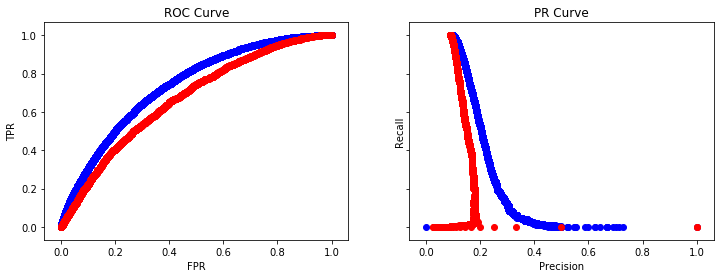

----- C = 0.050000 -----
Time elapsed (Training): 8.9651 s
LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906087
ROCAUC Score (Training): 0.732852
PRAUC Score (Training): 0.162035
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.672899
PRAUC Score (Validation): 0.062905
Time elapsed (Evaluation): 1.6785 s


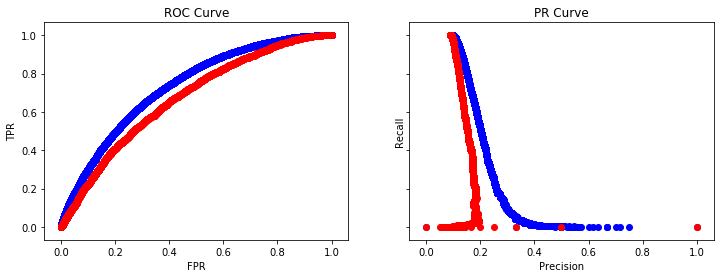

----- C = 0.020000 -----
Time elapsed (Training): 6.3110 s
LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.726831
PRAUC Score (Training): 0.108447
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.676119
PRAUC Score (Validation): 0.062420
Time elapsed (Evaluation): 1.6665 s


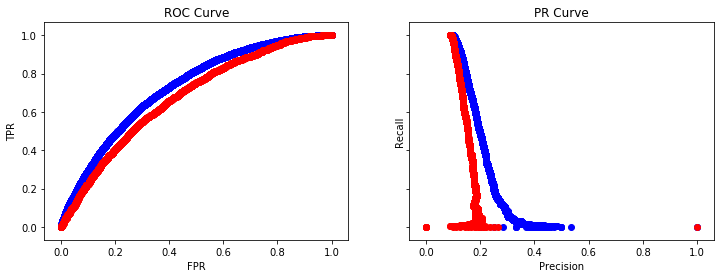

----- C = 0.010000 -----
Time elapsed (Training): 6.0841 s
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.721433
PRAUC Score (Training): 0.103516
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.678168
PRAUC Score (Validation): 0.107910
Time elapsed (Evaluation): 1.6715 s


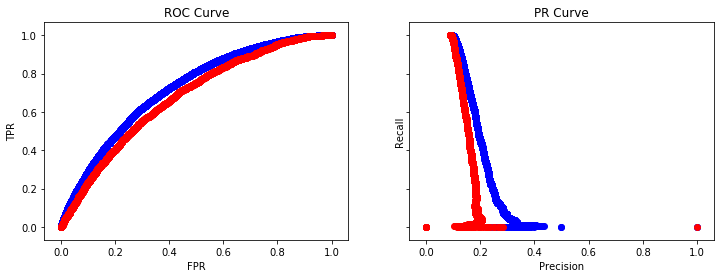

----- C = 0.005000 -----
Time elapsed (Training): 5.0964 s
LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.715435
PRAUC Score (Training): 0.098156
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.679468
PRAUC Score (Validation): 0.108465
Time elapsed (Evaluation): 1.8334 s


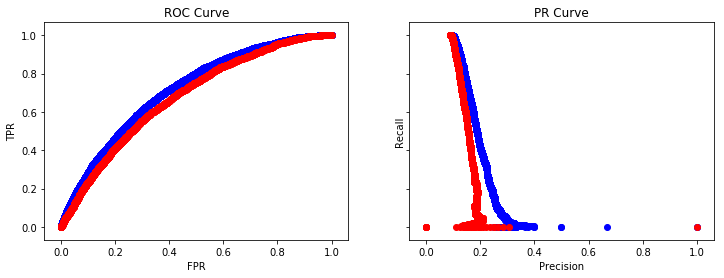

----- C = 0.002000 -----
Time elapsed (Training): 4.2436 s
LogisticRegression(C=0.002, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.706585
PRAUC Score (Training): 0.090713
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.679394
PRAUC Score (Validation): 0.108114
Time elapsed (Evaluation): 1.8654 s


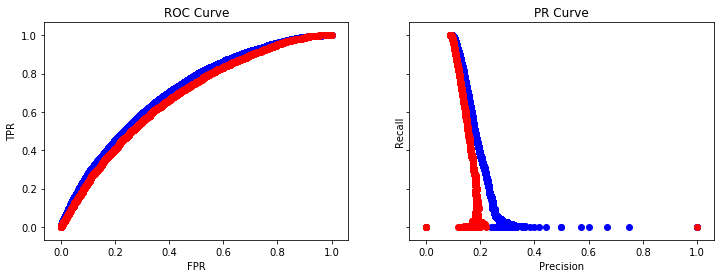

----- C = 0.001000 -----
Time elapsed (Training): 3.6618 s
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.699279
PRAUC Score (Training): 0.084966
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.677648
PRAUC Score (Validation): 0.068248
Time elapsed (Evaluation): 1.7634 s


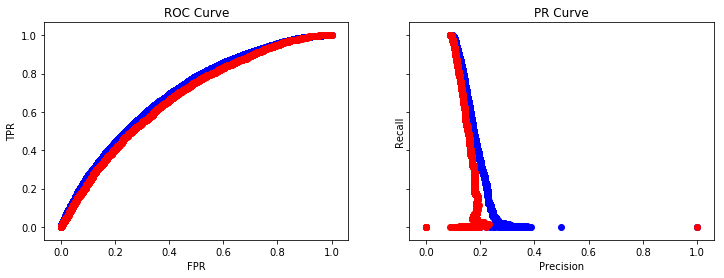

----- C = 0.000500 -----
Time elapsed (Training): 3.8568 s
LogisticRegression(C=0.0005, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.691618
PRAUC Score (Training): 0.079341
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.674626
PRAUC Score (Validation): 0.069372
Time elapsed (Evaluation): 2.0623 s


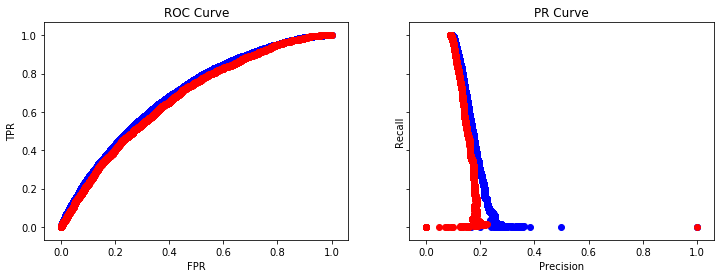

----- C = 0.000200 -----
Time elapsed (Training): 2.4992 s
LogisticRegression(C=0.0002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.681302
PRAUC Score (Training): 0.073050
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.668943
PRAUC Score (Validation): 0.083368
Time elapsed (Evaluation): 1.8304 s


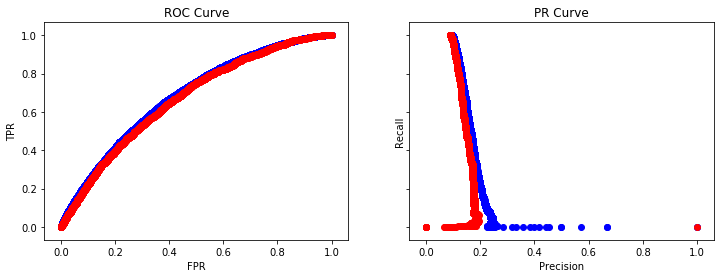

----- C = 0.000100 -----
Time elapsed (Training): 3.2130 s
LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.673649
PRAUC Score (Training): 0.069684
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.663728
PRAUC Score (Validation): 0.075938
Time elapsed (Evaluation): 2.0334 s


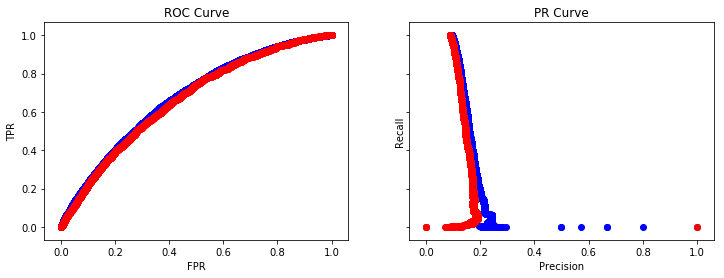

In [22]:
# Train the models with path features only

fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for C in Cs:
    print('----- C = %f -----' % C)
    clf = linear_model.LogisticRegression(C=C)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

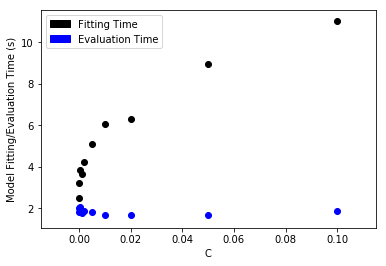

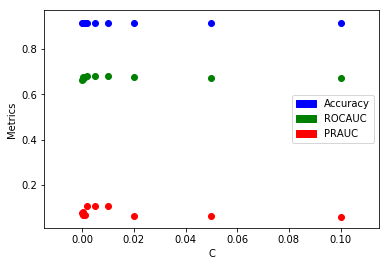

      0_C  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0  0.1000    0.911875  0.670354  0.059132   11.049479     1.883400
1  0.0500    0.911827  0.672899  0.062905    8.965145     1.678466
2  0.0200    0.911827  0.676119  0.062420    6.310989     1.666471
3  0.0100    0.911827  0.678168  0.107910    6.084061     1.671468
4  0.0050    0.911827  0.679468  0.108465    5.096376     1.833416
5  0.0020    0.911827  0.679394  0.108114    4.243649     1.865406
6  0.0010    0.911827  0.677648  0.068248    3.661833     1.763439
7  0.0005    0.911827  0.674626  0.069372    3.856771     2.062343
8  0.0002    0.911827  0.668943  0.083368    2.499204     1.830417
9  0.0001    0.911827  0.663728  0.075938    3.212976     2.033352


             0_C  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count  10.000000   10.000000  10.000000  10.000000   10.000000    10.000000
mean    0.018880    0.911832   0.674135   0.080587    5.498048     1.828818
std     0.032431    0.000015   0.

In [23]:
utils.plot_metrics(Cs, 'C', True, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

----- C = 0.100000 -----
Time elapsed (Training): 17.6404 s
LogisticRegression(C=0.1, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.617711
ROCAUC Score (Training): 0.740866
PRAUC Score (Training): 0.116990
Accuracy (Validation): 0.602512
ROCAUC Score (Validation): 0.664222
PRAUC Score (Validation): 0.058768
Time elapsed (Evaluation): 1.3786 s


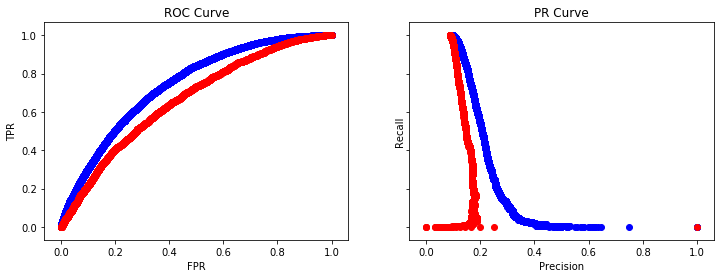

----- C = 0.050000 -----
Time elapsed (Training): 8.6582 s
LogisticRegression(C=0.05, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.617462
ROCAUC Score (Training): 0.739403
PRAUC Score (Training): 0.115100
Accuracy (Validation): 0.602655
ROCAUC Score (Validation): 0.665978
PRAUC Score (Validation): 0.057803
Time elapsed (Evaluation): 1.3116 s


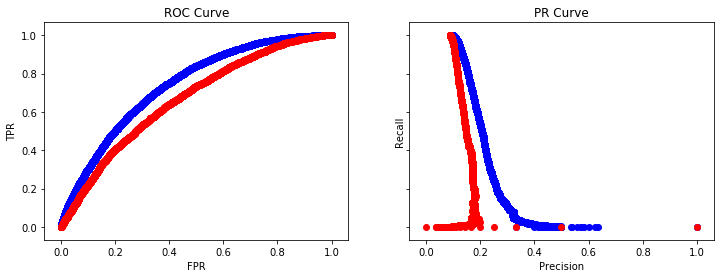

----- C = 0.020000 -----
Time elapsed (Training): 7.3937 s
LogisticRegression(C=0.02, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.615400
ROCAUC Score (Training): 0.736330
PRAUC Score (Training): 0.111818
Accuracy (Validation): 0.603129
ROCAUC Score (Validation): 0.669048
PRAUC Score (Validation): 0.059876
Time elapsed (Evaluation): 1.2746 s


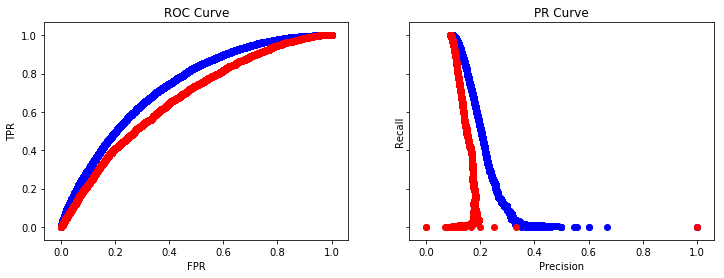

----- C = 0.010000 -----
Time elapsed (Training): 6.3480 s
LogisticRegression(C=0.01, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.613871
ROCAUC Score (Training): 0.732968
PRAUC Score (Training): 0.157352
Accuracy (Validation): 0.602797
ROCAUC Score (Validation): 0.671788
PRAUC Score (Validation): 0.105040
Time elapsed (Evaluation): 1.3666 s


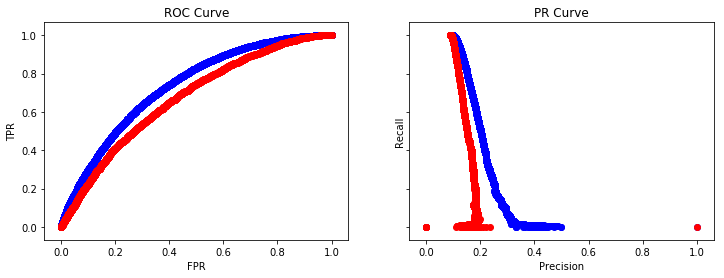

----- C = 0.005000 -----
Time elapsed (Training): 4.7965 s
LogisticRegression(C=0.005, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.609925
ROCAUC Score (Training): 0.728688
PRAUC Score (Training): 0.153827
Accuracy (Validation): 0.603318
ROCAUC Score (Validation): 0.674618
PRAUC Score (Validation): 0.106325
Time elapsed (Evaluation): 1.3096 s


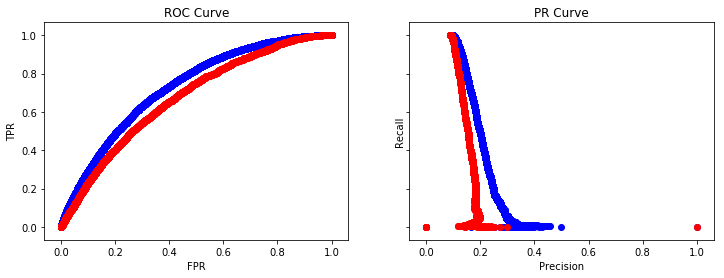

----- C = 0.002000 -----
Time elapsed (Training): 3.7358 s
LogisticRegression(C=0.002, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.603702
ROCAUC Score (Training): 0.721819
PRAUC Score (Training): 0.100463
Accuracy (Validation): 0.602038
ROCAUC Score (Validation): 0.678033
PRAUC Score (Validation): 0.108472
Time elapsed (Evaluation): 1.3386 s


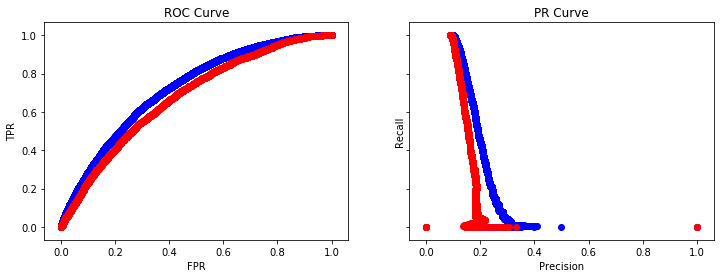

----- C = 0.001000 -----
Time elapsed (Training): 3.3419 s
LogisticRegression(C=0.001, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.598831
ROCAUC Score (Training): 0.715868
PRAUC Score (Training): 0.095672
Accuracy (Validation): 0.598199
ROCAUC Score (Validation): 0.679840
PRAUC Score (Validation): 0.109014
Time elapsed (Evaluation): 1.3886 s


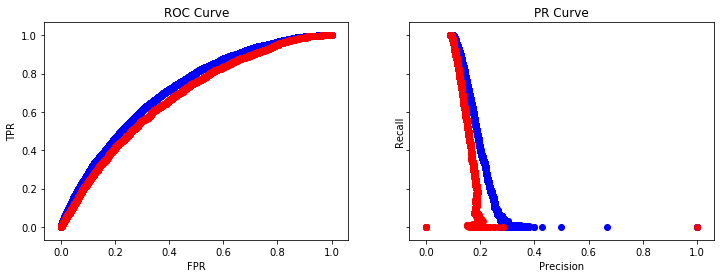

----- C = 0.000500 -----
Time elapsed (Training): 2.8571 s
LogisticRegression(C=0.0005, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.592135
ROCAUC Score (Training): 0.709278
PRAUC Score (Training): 0.090782
Accuracy (Validation): 0.594217
ROCAUC Score (Validation): 0.680420
PRAUC Score (Validation): 0.113291
Time elapsed (Evaluation): 1.3136 s


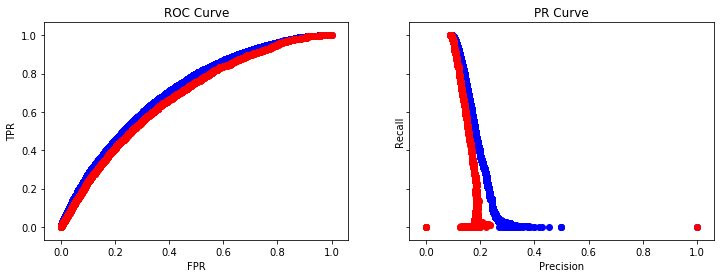

----- C = 0.000200 -----
Time elapsed (Training): 2.4352 s
LogisticRegression(C=0.0002, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.582820
ROCAUC Score (Training): 0.699643
PRAUC Score (Training): 0.083683
Accuracy (Validation): 0.587153
ROCAUC Score (Validation): 0.679005
PRAUC Score (Validation): 0.071859
Time elapsed (Evaluation): 1.3936 s


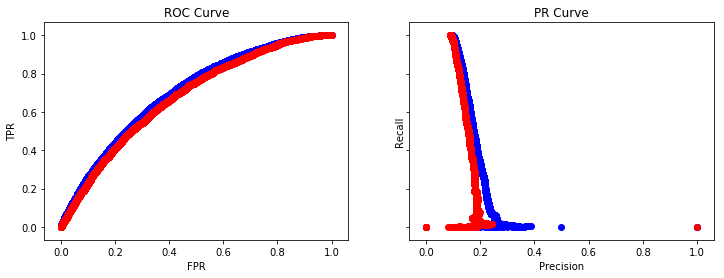

----- C = 0.000100 -----
Time elapsed (Training): 2.3592 s
LogisticRegression(C=0.0001, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.574239
ROCAUC Score (Training): 0.691923
PRAUC Score (Training): 0.125809
Accuracy (Validation): 0.580232
ROCAUC Score (Validation): 0.676350
PRAUC Score (Validation): 0.074790
Time elapsed (Evaluation): 1.2896 s


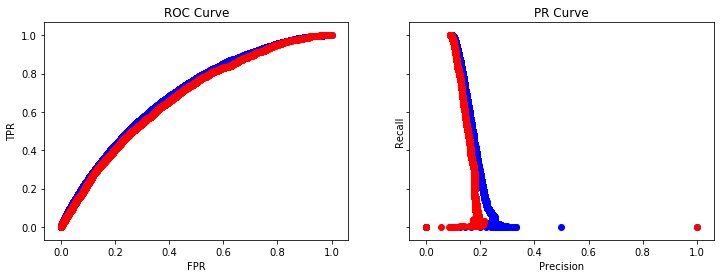

In [24]:
# Train the models with path features and class weights

fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for C in Cs:
    print('----- C = %f -----' % C)
    clf = linear_model.LogisticRegression(class_weight=class_weight, C=C)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

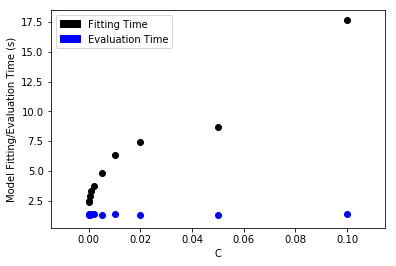

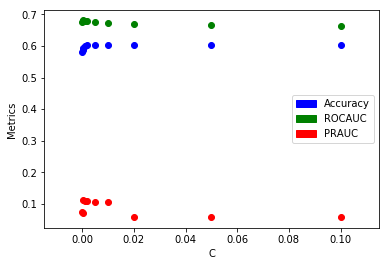

      0_C  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0  0.1000    0.602512  0.664222  0.058768   17.640380     1.378559
1  0.0500    0.602655  0.665978  0.057803    8.658241     1.311564
2  0.0200    0.603129  0.669048  0.059876    7.393661     1.274579
3  0.0100    0.602797  0.671788  0.105040    6.347977     1.366550
4  0.0050    0.603318  0.674618  0.106325    4.796474     1.309562
5  0.0020    0.602038  0.678033  0.108472    3.735796     1.338573
6  0.0010    0.598199  0.679840  0.109014    3.341935     1.388557
7  0.0005    0.594217  0.680420  0.113291    2.857088     1.313581
8  0.0002    0.587153  0.679005  0.071859    2.435224     1.393556
9  0.0001    0.580232  0.676350  0.074790    2.359234     1.289589


             0_C  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count  10.000000   10.000000  10.000000  10.000000   10.000000    10.000000
mean    0.018880    0.597625   0.673930   0.086524    5.956601     1.336467
std     0.032431    0.008043   0.

In [25]:
utils.plot_metrics(Cs, 'C', True, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)